In [13]:
!pip install wordcloud -q > /dev/null 2>&1
!pip install spacy -q > /dev/null 2>&1
!python -m spacy download fr_core_news_sm > /dev/null 2>&1

print("------------Packages downloaded-----------")


------------Packages downloaded-----------


In [2]:
import spacy
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_distances
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from collections import Counter
from scipy.spatial.distance import pdist, squareform, cdist
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from sklearn.manifold import TSNE

# 1. Cleaning data and preprocessing

Based on the results of the descriptive statistics, we construct a dataframe containing the document identifier, the year, the political party (identified by the variable "titulaire-soutien"), as well as the content of the manifesto. We retain only those manifestos for which a supporting political party is explicitly identified. Furthermore, in order to ensure class representativeness, we exclude political parties associated with fewer than 30 manifestos.

In [3]:
from create_dataframe import prepare_legislatives_dataset

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final = prepare_legislatives_dataset(csv_p, txt_p)

print("------------Df created-----------")

------------Df created-----------


Before implementing logistic regression, we will do:
1. **OCR artifact cleaning:** remove line breaks, special characters, and isolated small numbers.
2. **Text normalization:** convert text to lowercase, remove unnecessary punctuation.
3. **Tokenization and filtering:** remove stopwords, punctuation, and whitespace tokens.
4. **Lemmatization:** reduce words to their base form.
5. **Filter rare words**

These operations reduce noise, standardize the text, and retain only meaningful lexical information, thereby improving the robustness and interpretability of subsequent NLP models.

In [4]:
############# Load the French language model ############

nlp = spacy.load("fr_core_news_sm")

# We include additional stopwords that are specific to our corpus
custom_stops = ["candidat", "suppléant", "circonscription", "cest"]
for word in custom_stops:
    nlp.vocab[word].is_stop = True

In [5]:
############# functions to clean data ############

def preprocess_text(text, use_lemma=True):
    """Full preprocessing: OCR cleaning + tokenization + stopwords removal + lemmatization."""
    
    # --- OCR cleaning ---
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\w\s\.,;!?]', '', text)
    text = re.sub(r'\b\d{1,2}\b', '', text)
    
    # --- Lowercase + spaCy processing ---
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha and len(token) > 2:
            tokens.append(token.lemma_ if use_lemma else token.text)
    
    return " ".join(tokens)


def filter_rare_words(corpus, min_docs=5):
    """
    Filter out words appearing in fewer than min_docs documents.
    
    Parameters:
        corpus : List of preprocessed text strings.
        min_docs : Minimum number of documents a word must appear in to be kept.
            
    Returns:
        filtered_corpus : Corpus with rare words removed.
    """
    # Compute document frequency
    doc_freq = Counter()
    for text in corpus:
        for word in set(text.split()):
            doc_freq[word] += 1

    # Keep words appearing in at least min_docs documents
    vocab = {word for word, freq in doc_freq.items() if freq >= min_docs}

    # Filter each document
    filtered_corpus = [" ".join([word for word in text.split() if word in vocab])
                       for text in corpus]
    
    return filtered_corpus

# Execution
print("Starting text cleaning with spaCy (this may take 1–2 minutes)...")
df_final["clean_text"] = df_final["text_content"].apply(preprocess_text)
df_final["clean_text_filtered"] = filter_rare_words(df_final["clean_text"], min_docs=5)
print("Text cleaning completed")




Starting text cleaning with spaCy (this may take 1–2 minutes)...
Text cleaning completed


## 1.2 Wordclouds for each category

We begin by generating word clouds for each category in order to obtain an initial qualitative insight into the existence of a “signature” vocabulary for each party, as well as a preliminary mapping of parties that display similar lexical patterns.

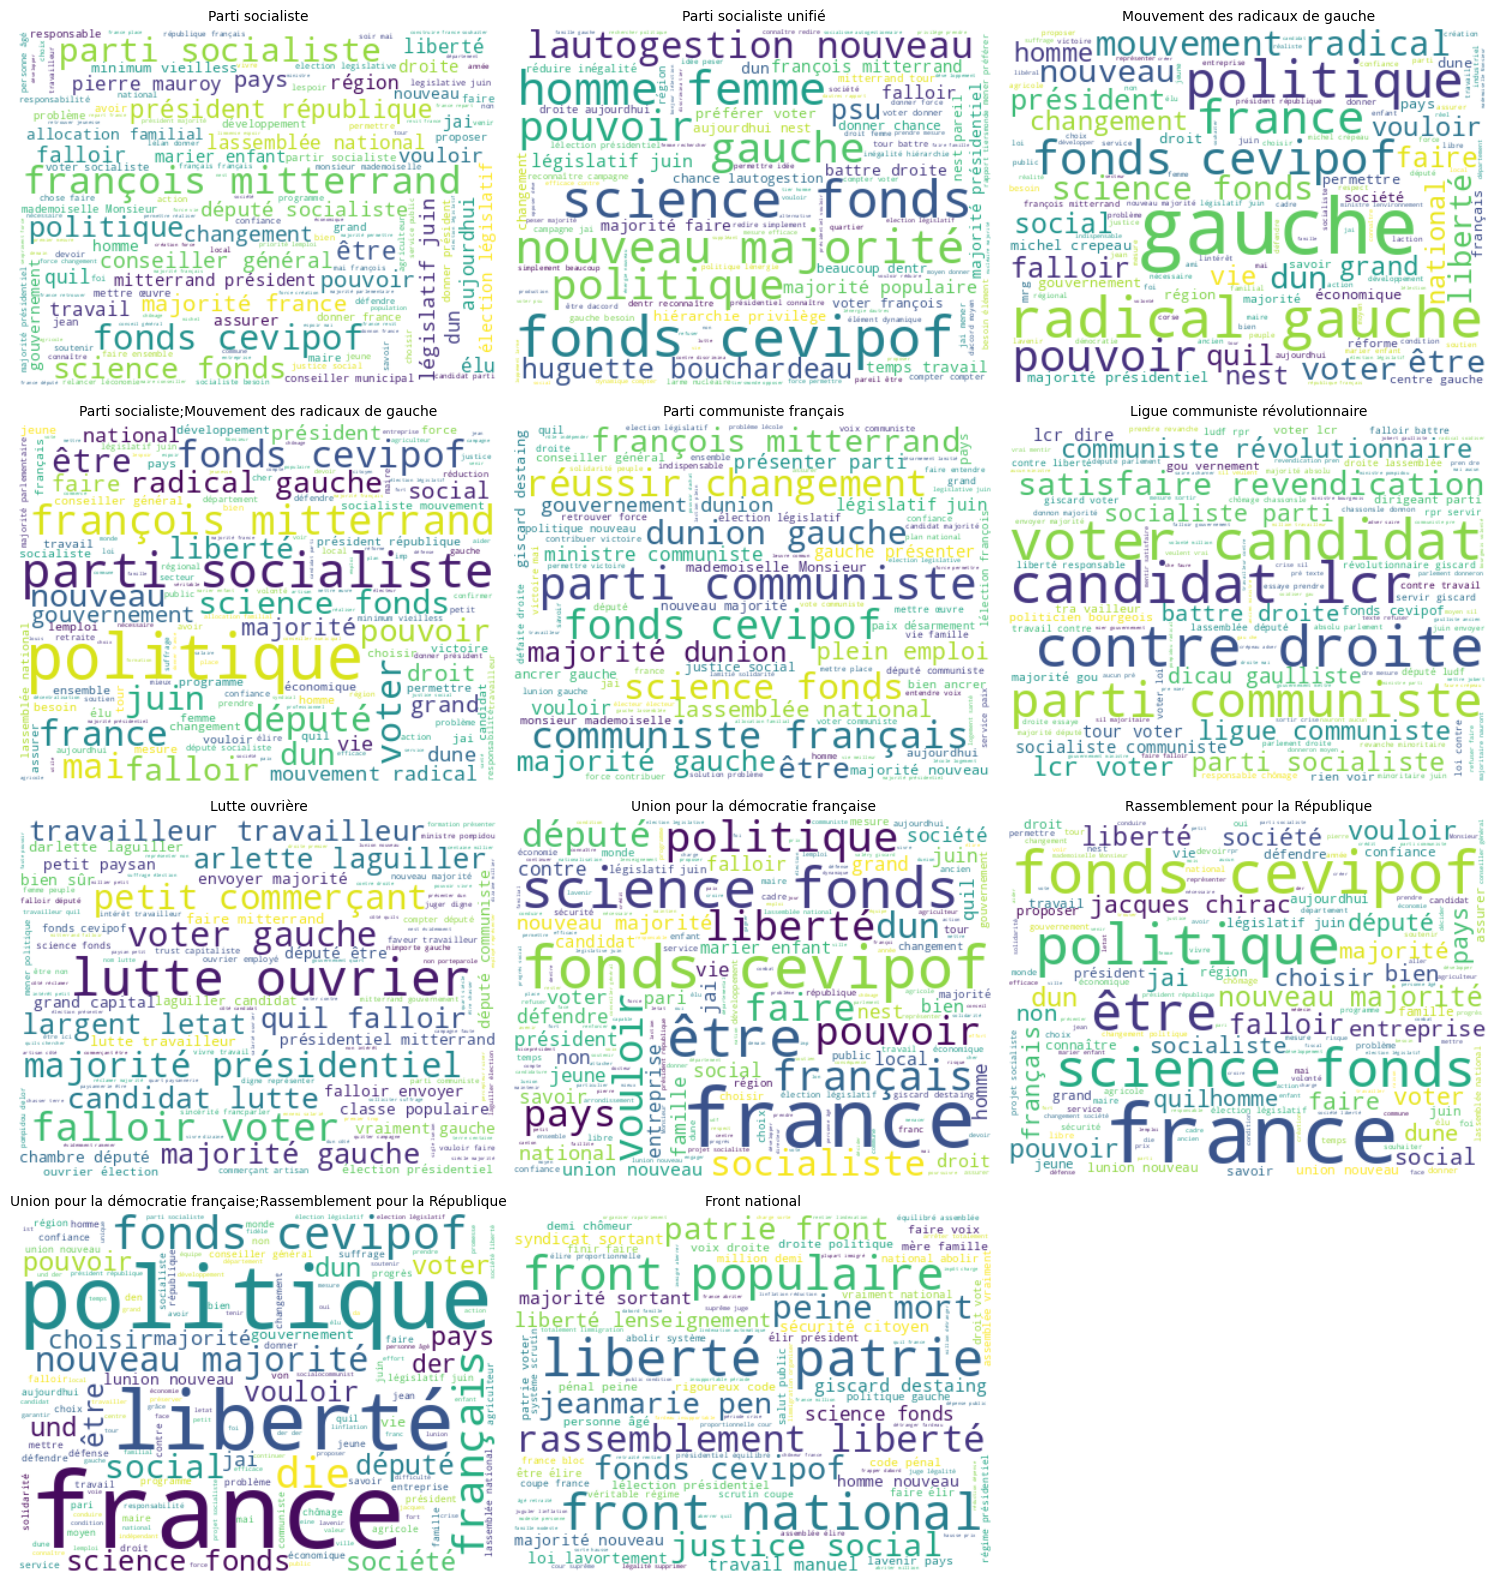

In [ ]:
########################### Worldclouds for each category #############################

# List of categories in a specific order
categories = [
    "Parti socialiste", "Parti socialiste unifié",
    "Mouvement des radicaux de gauche", "Parti socialiste;Mouvement des radicaux de gauche",
    "Parti communiste français", "Ligue communiste révolutionnaire", "Lutte ouvrière",
    "Union pour la démocratie française", "Rassemblement pour la République",
    "Union pour la démocratie française;Rassemblement pour la République", "Front national"
]

## Create a figure with subplots

# Number of columns for display and automatically computation of the number of rows
n_cols = 3
n_rows = (len(categories) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  

# Loop over categories to generate WordClouds
for i, cat in enumerate(categories):
    # Merge all preprocessed texts for the current category
    text_cat = " ".join(df_final[df_final['titulaire-soutien'] == cat]['clean_text_filtered'].astype(str))
    
    if text_cat.strip():  
        # Generate Wordcloud
        wc = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis'
        ).generate(text_cat)
        
        # Display the WordCloud in the subplot
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(cat, fontsize=10)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{cat} (no data)", fontsize=10)


# Remove unused axes if the number of categories is not a multiple of n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# 2. Regression logistic's implementation (first test without fusioning or deleting categories)

We first define a function to implement the logistic regression with TF-IDF features as we will implemente the model two times.

As we have some categories with a small number of manifestos, we will use stratified cross-validation and hyperparameter tuning. Futhermore, since the categories are imbalanced, our goal is to  maximize F1 score and we will use `class_weight='balanced'` to give more importance to minority classes.

In [6]:
## Function to implemente regression logistic

def logistic_regression_nlp(df, text_col="vlean_text_filtered", label_col="titulaire-soutien", min_docs=5, cv_folds=5, random_state=42):
    """
    Performs logistic regression on NLP text data with TF-IDF features using Stratified CV.

    Parameters:
        df : DataFrame containing text and labels
        min_docs : Minimum number of documents a word must appear in
        cv_folds : Number of folds for StratifiedKFold
        random_state : Random state for reproducibility

    Returns:
        best_model : trained Pipeline with the best hyperparameters and confusion matrice
    """

    X = df["clean_text_filtered"].astype(str)
    y = df[label_col].astype(str)

    # Pipeline
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("lr", LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])


    # Hyperparameter grid
    param_grid = {
        'tfidf__max_features': [1000, 3000, 5000],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'lr__C': [0.1, 1.0, 10.0]
    }

    # GridSearch 
    #    # StratifiedKFold → conserve the proportion of each class in each fold
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    grid = GridSearchCV(pipe, param_grid, scoring='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X, y)

       # Best model
    best_model = grid.best_estimator_
    print("=== BEST PIPELINE ===")
    display(best_model)
    display(f"✅ Best hyperparameters: {grid.best_params_}, F1 (CV): {grid.best_score_:.4f}")

    # Cross-val predictions pour classification report et confusion matrix
    y_pred = cross_val_predict(best_model, X, y, cv=cv)
    print("\n--- CLASSIFICATION REPORT (CV) ---")
    print(classification_report(y, y_pred))

    fig, ax = plt.subplots(figsize=(20,10))
    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    plt.title("Confusion Matrix (CV)")
    plt.tight_layout()
    plt.show()

    return best_model


Fitting 5 folds for each of 18 candidates, totalling 90 fits


=== BEST PIPELINE ===


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


"✅ Best hyperparameters: {'lr__C': 1.0, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.8979"


--- CLASSIFICATION REPORT (CV) ---
                                                                     precision    recall  f1-score   support

                                                     Front national       1.00      0.98      0.99        44
                                   Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                                                     Lutte ouvrière       1.00      0.99      1.00       159
                                   Mouvement des radicaux de gauche       1.00      0.89      0.94        46
                                          Parti communiste français       1.00      0.99      0.99       463
                                                   Parti socialiste       0.95      0.97      0.96       407
                                            Parti socialiste unifié       1.00      0.99      0.99       148
                  Parti socialiste;Mouvement des radicaux de gauche       0.71      0.50   

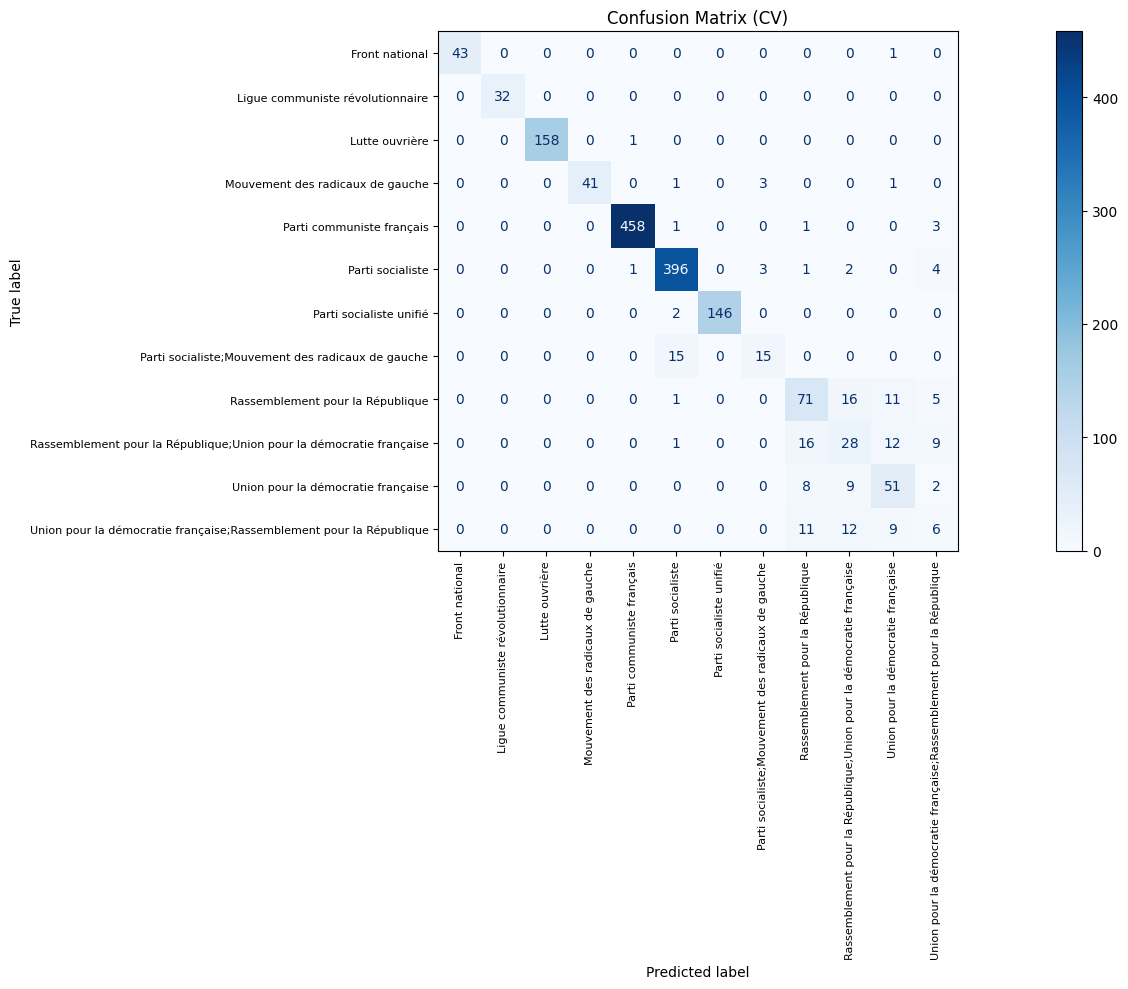

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [7]:
######################"""" Implementation of the logistic regression (with bi-categories) #########################
logistic_regression_nlp(df_final, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

As we had anticipated from the word clouds, the classification of manifestos with dual support performs poorly (F1-score ranging from 0.18 to 0.59). We therefore choose to implement a second logistic regression by excluding these categories, in order to minimize noise and confusion.

# 3. Logistic regression (after deleting the bi-support categories)

## 3.1 Model implementation

Fitting 5 folds for each of 18 candidates, totalling 90 fits
=== BEST PIPELINE ===


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


"✅ Best hyperparameters: {'lr__C': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.9736"


--- CLASSIFICATION REPORT (CV) ---
                                    precision    recall  f1-score   support

                    Front national       1.00      0.98      0.99        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      1.00      1.00       159
  Mouvement des radicaux de gauche       1.00      0.93      0.97        46
         Parti communiste français       1.00      0.99      1.00       463
                  Parti socialiste       0.98      0.99      0.99       407
           Parti socialiste unifié       1.00      0.99      0.99       148
  Rassemblement pour la République       0.86      0.85      0.85       104
Union pour la démocratie française       0.79      0.84      0.81        70

                          accuracy                           0.97      1473
                         macro avg       0.96      0.95      0.96      1473
                      weighted avg       0.97     

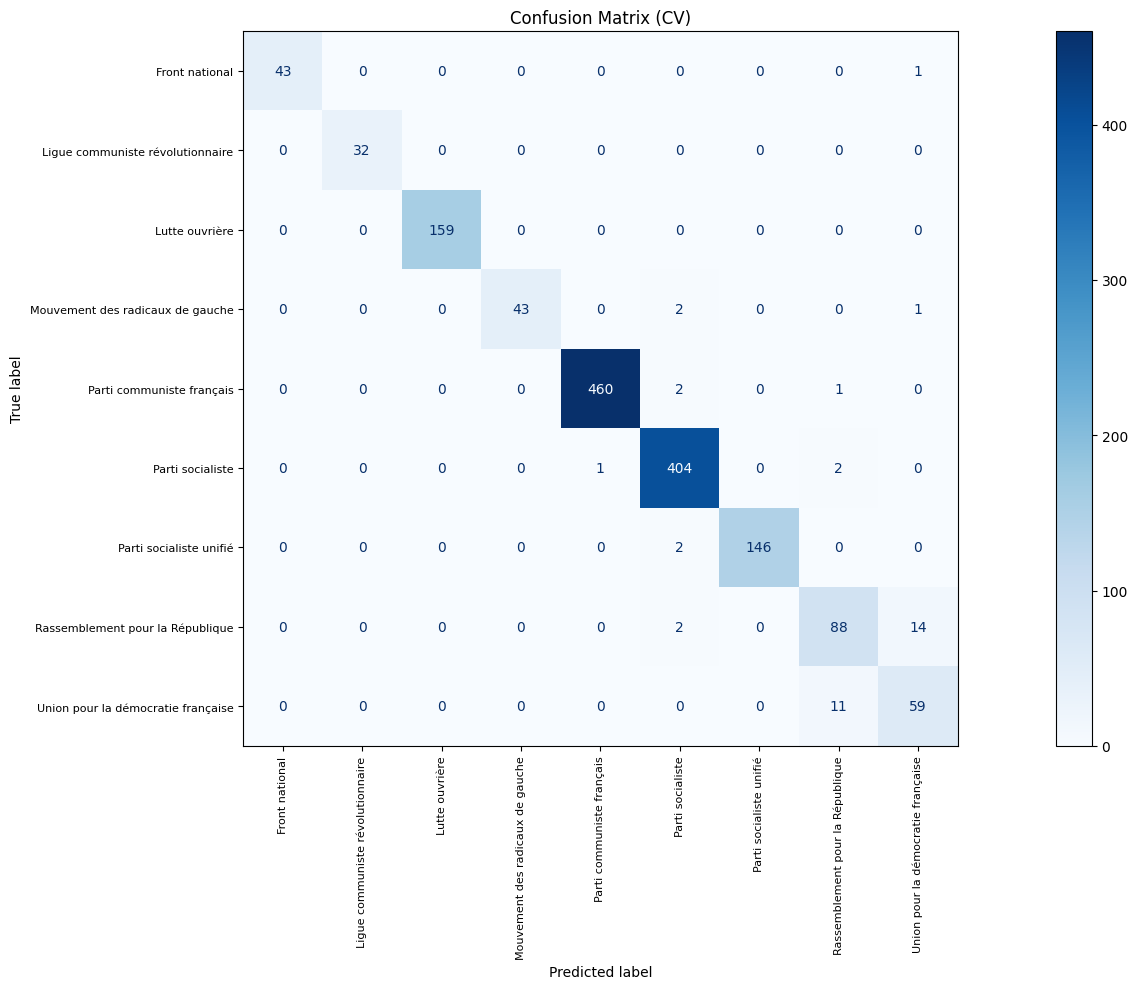

In [8]:
# Deleting the bi-support categories
categories_a_supprimer = ['Parti socialiste;Mouvement des radicaux de gauche', 'Rassemblement pour la République;Union pour la démocratie française',  'Union pour la démocratie française;Rassemblement pour la République']
df_final_sans_cat_mixte = df_final[~df_final['titulaire-soutien'].isin(categories_a_supprimer)]

# Implementation of the logistic regression
best_model =logistic_regression_nlp(df_final_sans_cat_mixte, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

This second regression yields good classification (macro f1-score de 0,96) results and will serve as our baseline.

## 3.2 Coefficients' interpretation

We will now identify the words that are most discriminative for the classification performed by the logistic regression.
For better readability, positive coefficients will be displayed in blue and negative coefficients in red.

In [27]:
################## This block builds formatted tables of the most discriminant words ######################

def build_party_table_abs(cat, top_n=10):
    """
    Build a table of the top |coef| features for a given party.

    Input: party/class name.

    Output: table with top_n features and their coefficients.
    """
    df_class = coef_df[coef_df['class'] == cat].copy()
    
    # Rank features by absolute coefficient magnitude
    df_class["abs_coef"] = df_class["coef"].abs()
    top_abs = df_class.sort_values("abs_coef", ascending=False).head(top_n)
    
    table = top_abs[["feature", "coef"]].reset_index(drop=True)
    table.columns = [f"{cat} - mot", f"{cat} - coef"]
    
    return table


def color_coef(val):
    """
    Assign color styling based on coefficient sign.

    Input: logistic regression coefficient.

    Output: CSS style (blue for positive, red for negative).
    """
    if val > 0:
        return "color: #1f77b4; font-weight: bold;"  # blue
    elif val < 0:
        return "color: #d62728; font-weight: bold;"  # red
    else:
        return ""


def display_three_parties_abs(categories, n_cols=3, top_n=10):
    """
    Display styled tables of top |coef| features for parties,
    grouped by rows of n_cols parties.

    Input: 
        categories: list of party names.
        n_cols: number of parties displayed per row.

    Output: None
    """
    for i in range(0, len(categories), n_cols):
        block = categories[i:i+n_cols]
        
        tables = [build_party_table_abs(cat, top_n=top_n) for cat in block]
        combined = pd.concat(tables, axis=1)
        
        coef_cols = [col for col in combined.columns if "coef" in col]
        
        styled = combined.style.applymap(color_coef, subset=coef_cols)
        display(styled)


In [29]:
############### Application of the display_three_parties_abs function #########################

# Coefficients of the best model (trained before)
lr = best_model.named_steps["lr"]
vectorizer = best_model.named_steps["tfidf"]

# Get feature names (words) from TF-IDF, coef from logistic regression and  class labels
feature_names = vectorizer.get_feature_names_out()
coefs = lr.coef_
classes = lr.classes_

# Keep only the classes actually used in the logistic regression
categories= [c for c in categories if c in best_model.classes_]

# Cobnstruct a list, then a df, to store coefficients for each word and class
rows = []

for i, class_label in enumerate(classes):
    for feature, coef in zip(feature_names, coefs[i]):
        rows.append({
            "class": class_label,
            "feature": feature,
            "coef": coef
        })

coef_df = pd.DataFrame(rows)

# Application of the function
display_three_parties_abs(categories)

/tmp/ipykernel_256615/3589752579.py:58: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Parti socialiste - mot,Parti socialiste - coef,Parti socialiste unifié - mot,Parti socialiste unifié - coef,Mouvement des radicaux de gauche - mot,Mouvement des radicaux de gauche - coef
0,socialiste,0.825743,psu,0.915120,radical,1.505666
1,parti socialiste,0.634459,nucléaire,0.715608,radical gauche,1.501416
2,président,0.499232,lautogestion,0.695401,mouvement radical,1.046588
3,gauche,-0.495413,autogestionnaire,0.495308,gauche,0.856197
4,françois mitterrand,0.486182,populaire,0.469340,michel,0.625558
5,communiste,-0.474356,femme,0.410770,mrg,0.587982
6,françois,0.458488,alternative,0.395890,mouvement,0.544926
7,france,0.430993,bouchardeau,0.389071,michel crepeau,0.530977
8,majorité france,0.381376,hiérarchie,0.388738,crepeau,0.530977
9,mitterrand,0.362701,majorité populaire,0.386947,centre gauche,0.441957


/tmp/ipykernel_256615/3589752579.py:58: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Parti communiste français - mot,Parti communiste français - coef,Ligue communiste révolutionnaire - mot,Ligue communiste révolutionnaire - coef,Lutte ouvrière - mot,Lutte ouvrière - coef
0,communiste,1.332198,lcr,0.798989,lutte ouvrier,0.810598
1,dunion,0.621021,candidat lcr,0.526635,ouvrier,0.712609
2,réussir,0.607222,lunité,0.519616,lutte,0.665049
3,gauche,0.556299,patron,0.469339,travailleur,0.622192
4,changement,0.521436,contre,0.390651,laguiller,0.493262
5,communiste français,0.487662,satisfaire revendication,0.366191,mitterrand,0.439255
6,parti communiste,0.477603,voie,0.362028,falloir voter,0.413458
7,réussir changement,0.463881,droite,0.360905,chambre,0.407315
8,dunion gauche,0.407414,revendication,0.355174,trop,0.406326
9,victoire,0.388602,voter candidat,0.350079,gauche,0.385010


/tmp/ipykernel_256615/3589752579.py:58: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Union pour la démocratie française - mot,Union pour la démocratie française - coef,Rassemblement pour la République - mot,Rassemblement pour la République - coef,Front national - mot,Front national - coef
0,gauche,-0.565680,jacques chirac,0.684902,front,0.974027
1,union,0.454790,jacques,0.550535,patrie,0.862725
2,union nouveau,0.388061,gauche,-0.520317,front national,0.728634
3,excès,0.350740,société,0.422027,liberté patrie,0.612704
4,enfant,0.314624,chirac,0.399972,rassemblement,0.498150
5,france,0.302714,liberté,0.339681,national,0.475219
6,udf,0.302356,union nouveau,0.327079,pen,0.454076
7,démocrate,0.296302,radical,-0.321702,jeanmarie pen,0.451355
8,radical gauche,-0.276108,nouveau majorité,0.284202,rassemblement liberté,0.441721
9,droite,-0.259057,oui,0.280969,jeanmarie,0.408038


# 4. Projection et indice de dissimilarité

## 4.1 Projection in 2D




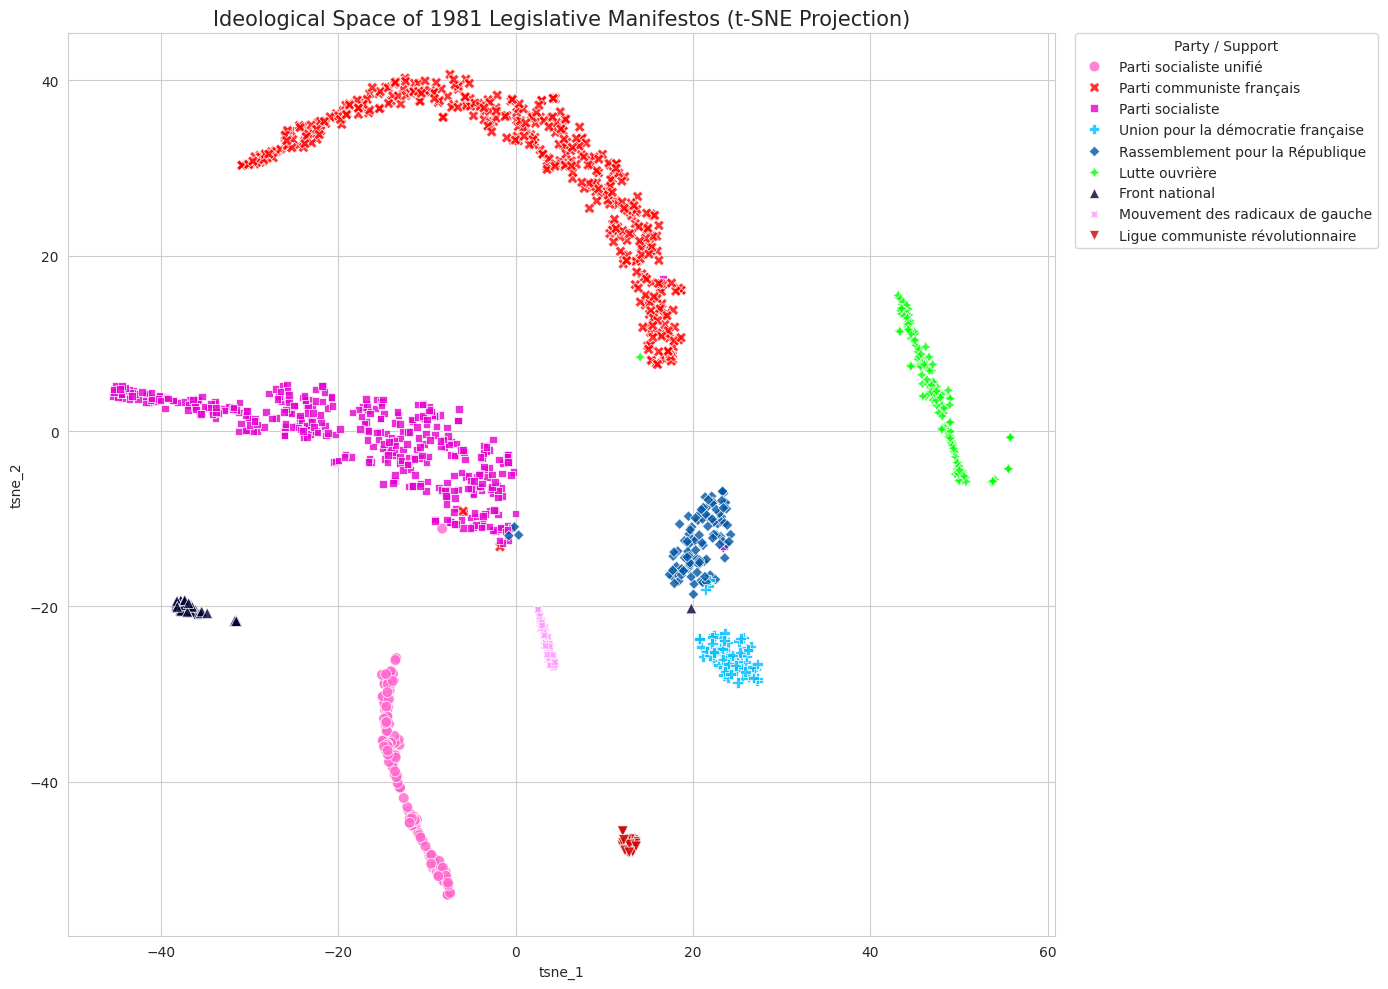

In [48]:
############################""  Visualizing the ideological space of the manifestos using 2D projection (t-SNE or UMAP)###################
#  Points are colored by party/support (titulaire-soutien)


#Get probabilities from the logistic regression model
probas = best_model.predict_proba(df_final_sans_cat_mixte['clean_text_filtered'].astype(str))  # shape (num_texts, n_classes)

# Convert probabilities to a DataFrame for easier handling
proba_df = pd.DataFrame(probas, columns=best_model.classes_)
df_final_sans_cat_mixte = df_final_sans_cat_mixte.reset_index(drop=True)
df_final_sans_cat_mixte = pd.concat([df_final_sans_cat_mixte, proba_df], axis=1)

# Compute 2D projection (t-SNE) 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(proba_df.values)  # Use probabilities as features
df_final_sans_cat_mixte['tsne_1'] = tsne_results[:, 0]
df_final_sans_cat_mixte['tsne_2'] = tsne_results[:, 1]

# Color palette
# ------------------- Custom color palette -------------------
custom_palette = {
    'Parti socialiste': '#E400D0',               # Pink
    'Parti socialiste unifié': '#FF66CC',        # Light Pink
    'Mouvement des radicaux de gauche': '#FF99FF', # Very light pink / lavender
    'Rassemblement pour la République': '#0055A4',  # Dark Blue
    'Union pour la démocratie française': '#00BFFF', # Light Blue
    'Parti communiste français': '#FF0000',     # Red
    'Ligue communiste révolutionnaire': '#CC0000', # Dark Red
    'Lutte ouvrière': '#00FF00',                # Green
    'Front national': '#000033',                # Dark Navy
    'Ecologiste': '#33CC33',                     # Dark Green
}


#  Scatterplot with improved visuals
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")  # Clean background for readability

plot = sns.scatterplot(
    data=df_final_sans_cat_mixte, 
    x='tsne_1',           # First 2D coordinate from projection
    y='tsne_2',           # Second 2D coordinate from projection
    hue='titulaire-soutien', 
    palette=custom_palette,  # Use custom colors
    style='titulaire-soutien',  # Different shapes per party for clarity
    alpha=0.8, 
    edgecolor='w', 
    s=60  # Point size
)

# Final touches
plt.title("Ideological Space of 1981 Legislative Manifestos (t-SNE Projection)", fontsize=15)
plt.legend(
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0, 
    title="Party / Support"
)
plt.tight_layout()
plt.show()


## 4.2 Indice de dissimiliraté entre les partis
Using coefficients from the logistic regression, we compute a semantic dissimilarity index between parties.
This index highlights which parties are semantically closest (similar) and which are most distant.
Diagonal: intra-party cohesion (1 - mean cosine similarity of texts within the party)
Off-diagonal: inter-party distance (cosine distance between party vectors= 1 -similarity between party vectors)

In [30]:
############### Build a coefficient matrix for all parties ( Rows = parties, Columns = features) ##########################

# Pivot the DataFrame to get a matrix: rows = classes, columns = features, values = coefficients
coef_matrix_df = coef_df.pivot(
    index="class",
    columns="feature",
    values="coef"
).fillna(0)

# Convert to numpy array
coef_matrix = coef_matrix_df.values



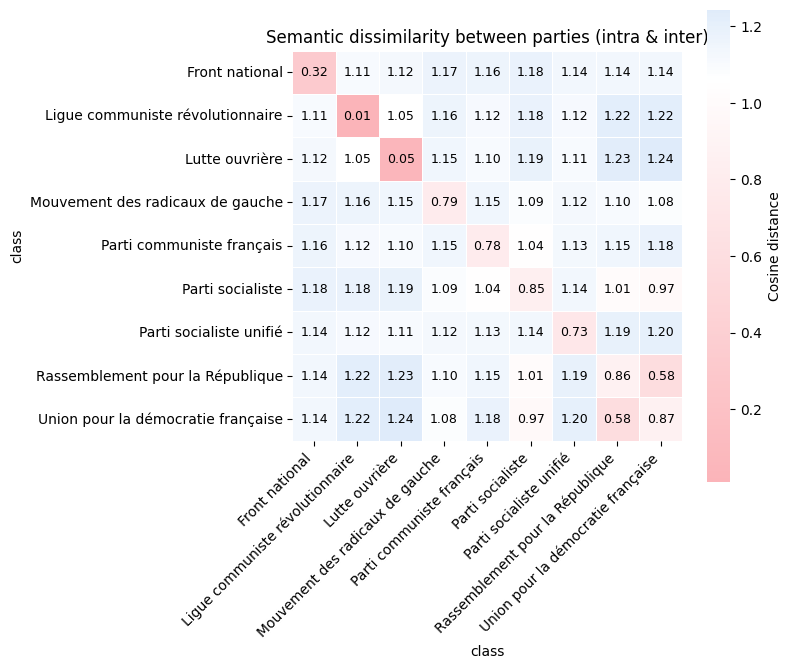

In [46]:
############ Compute and plot semantic dissimilarity between parties (combining inter-party distances and intra-party cohesion) ##################

#  Extract TF-IDF features from the pipeline 
X = best_model.named_steps['tfidf'].transform(df_final['clean_text_filtered']).toarray()

parties = df_final['titulaire-soutien'].unique()
intra_distances = {}

# Compute intra-party cohesion
for p in parties:
    mask = df_final['titulaire-soutien'] == p
    vectors = X[mask]
    
    # Cosine similarity matrix within the party
    sim_intra = cosine_similarity(vectors)

     # Take upper triangle only to ignore self-similarity
    upper_tri_indices = np.triu_indices(sim_intra.shape[0], k=1)

    # Convert similarity to distance
    mean_intra_sim = sim_intra[upper_tri_indices].mean() if len(upper_tri_indices[0]) > 0 else 1.0
    intra_distances[p] = 1 - mean_intra_sim

# Compute inter-party distances
dist_df_cos = pd.DataFrame(
    cosine_distances(coef_matrix),
    index=coef_matrix_df.index,
    columns=coef_matrix_df.index
)

# Copy for plotting
dist_plot = dist_df_cos.copy()

# Replace diagonal with intra-party distances
for p in parties:
    if p in dist_plot.index:
        dist_plot.loc[p, p] = intra_distances[p]

#  Plot the heatmap 
plt.figure(figsize=(8, 7))

# Define a soft pastel gradient: pale pink -> white -> light blue
colors = ["#fbb4b9", "white", "#4a90e2"]  
cmap = LinearSegmentedColormap.from_list("pastel_gradient", colors)

sns.heatmap(
    dist_plot,
    annot=True,               # Show numeric values
    fmt=".2f",
    cmap=cmap,
    center=dist_plot.mean().mean(),  # Center colormap on mean
    linewidths=0.5,
    cbar_kws={'label': 'Cosine distance'},
    square=True,
    annot_kws={"color": "black", "fontsize": 9}  # Annotation style
)

plt.title("Semantic dissimilarity between parties (intra & inter)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 5. Identification of outliers

## 5.1 Identify outliers by distance to the centroïd

We will begin by attempting to identify outliers using the distance to the centroid for each party.

In [9]:
########## Compute cosine distance to the party centroid ############################

# Extract TF-IDF features (used as the text representation)  from the logistic pipeline
X = best_model.named_steps['tfidf'].transform(
    df_final_sans_cat_mixte['clean_text_filtered']
).toarray()

#  Create a column to store distance to centroid
df_final_sans_cat_mixte['distance_au_centre'] = np.nan

# 3️ Compute party centroid and cosine distance
for parti in df_final_sans_cat_mixte['titulaire-soutien'].unique():
    
    # Select vectors belonging to the current party
    mask = df_final_sans_cat_mixte['titulaire-soutien'] == parti
    points_parti = X[mask]
    
    # Compute centroid (mean vector of the party)
    centre = points_parti.mean(axis=0).reshape(1, -1)
    
    # Compute cosine distance from each text to the centroid
    distances = cdist(points_parti, centre, metric='cosine').flatten()
    
    # Store distances in the DataFrame
    df_final_sans_cat_mixte.loc[mask, 'distance_au_centre'] = distances

/tmp/ipykernel_325771/3224065316.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_sans_cat_mixte['distance_au_centre'] = np.nan


Number of outliers per party:


titulaire-soutien
Lutte ouvrière                      26
Parti communiste français           18
Front national                      10
Parti socialiste                     3
Ligue communiste révolutionnaire     3
Rassemblement pour la République     2
Name: count, dtype: int64

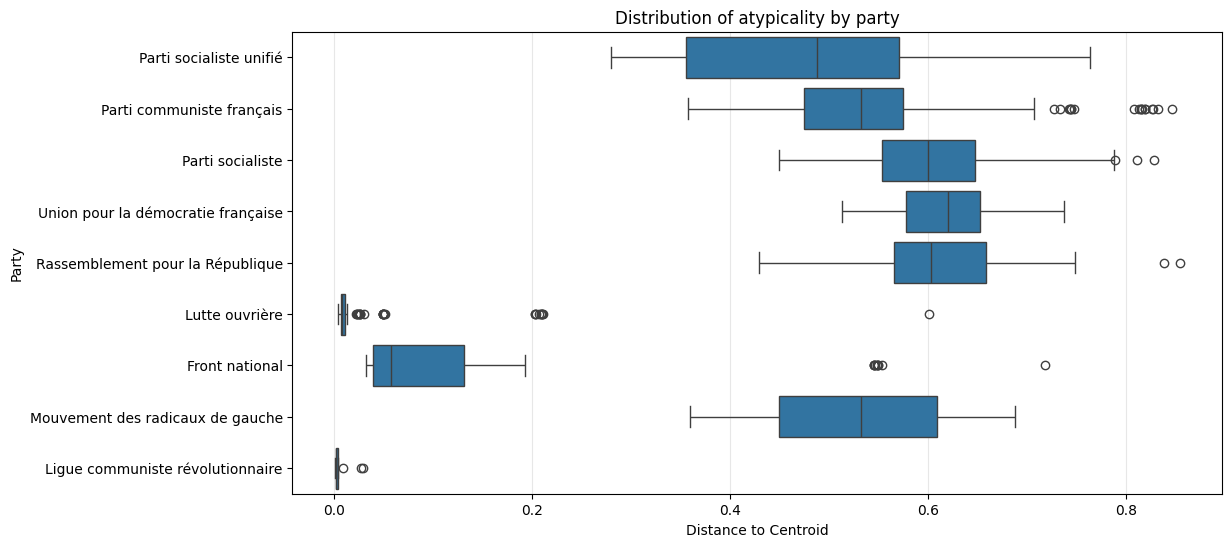

In [20]:
################## Distribution of outliers identified by the IQR rule on cosine distance to centroid ############

# Store outliers for each party
outliers_list = []

for parti in df_final_sans_cat_mixte['titulaire-soutien'].unique():
    
    # Select distances for the current party
    subset = df_final_sans_cat_mixte[
        df_final_sans_cat_mixte['titulaire-soutien'] == parti
    ]['distance_au_centre']
    
    # Compute quartiles and IQR
    Q1 = subset.quantile(0.25)
    Q3 = subset.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define upper bound (standard 1.5 * IQR rule)
    upper_bound = Q3 + 1.5 * IQR
    
    # Extract outliers (extreme distances)
    outliers = df_final_sans_cat_mixte[
        (df_final_sans_cat_mixte['titulaire-soutien'] == parti) &
        (df_final_sans_cat_mixte['distance_au_centre'] > upper_bound)
    ].copy()
    
    outliers_list.append(outliers)

# Concatenate all party-specific outliers
df_all_outliers = pd.concat(outliers_list)

# Count outliers per party
repartition = df_all_outliers['titulaire-soutien'].value_counts()

print("Number of outliers per party:")
display(repartition)

# Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final_sans_cat_mixte, x='distance_au_centre', y='titulaire-soutien')
plt.xlabel("Distance to Centroid")
plt.ylabel("Party")
plt.title("Distribution of atypicality by party")
plt.grid(axis='x', alpha=0.3)
plt.show()


In [ ]:
################## Proportion of misclassification among outliers ####################################

# Generating predictions for outliers
df_all_outliers['parti_predit'] = best_model.predict(df_all_outliers['clean_text_filtered'])

# Comparing predictions and true labels
df_all_outliers['est_mal_classe'] = df_all_outliers['titulaire-soutien'] != df_all_outliers['parti_predit']

# Proportion of outliers' misclassification per category
stats_outliers = df_all_outliers.groupby('titulaire-soutien').agg(
    total_outliers=('distance_au_centre', 'count'),
    nb_mal_classes=('est_mal_classe', 'sum')
)

stats_outliers['proportion_misclassification_%'] = (stats_outliers['nb_mal_classes'] / stats_outliers['total_outliers'] * 100).round(2)

print("Proportion of outliers' misclassification per category :")
display(stats_outliers.sort_values(by='total_outliers', ascending=False))

Proportion of outliers' misclassification per category :


,total_outliers,nb_mal_classes,proportion_misclassification_%
titulaire-soutien,,,
Lutte ouvrière,26,0,0.00
Parti communiste français,18,2,11.11
Front national,10,1,10.00
Ligue communiste révolutionnaire,3,0,0.00
Parti socialiste,3,0,0.00
Rassemblement pour la République,2,1,50.00


Given the table above, the distance to the centroid appears to be poorly suited for identifying outliers.

Identifying outliers by

Gemini a dit
Identifier les outliers via les probabilités d'appartenance (issues de votre régression logistique) est non seulement possible, mais c'est l'une des méthodes les plus pertinentes pour mesurer le "conflit interne" d'un document.

Alors que le K-NN mesure une distance physique (géographie), la probabilité mesure une ambiguïté sémantique.

1. Pourquoi est-ce pertinent ?
En régression logistique, le modèle calcule une probabilité pour chaque classe. Un document "normal" devrait avoir une probabilité très élevée (proche de 1.0) pour son parti réel et très faible pour les autres.

L'analyse des probabilités permet de repérer deux types d'outliers :

Les "Inclassables" : Le modèle donne des probabilités faibles partout (ex: 0.20 pour chaque parti). Le texte est trop neutre ou confus.

Les "Transfuges" : Le modèle est très confiant (0.90), mais pour le mauvais parti. C'est un outlier idéologique clair.

In [21]:
# 1. Obtenir les probabilités pour chaque classe
probas = best_model.predict_proba(df_final_sans_cat_mixte['clean_text_filtered'])
df_probas = pd.DataFrame(probas, columns=best_model.classes_, index=df_final_sans_cat_mixte.index)

# 2. Extraire la probabilité affectée au parti RÉEL
def get_vrai_parti_proba(row):
    parti_reel = row['titulaire-soutien']
    return df_probas.loc[row.name, parti_reel]

df_final_sans_cat_mixte['proba_parti_reel'] = df_final_sans_cat_mixte.apply(get_vrai_parti_proba, axis=1)

# 3. Identifier les outliers de confiance
# Un score proche de 0 signifie que le modèle ne reconnaît absolument pas le parti annoncé
outliers_proba = df_final_sans_cat_mixte[df_final_sans_cat_mixte['proba_parti_reel'] < 0.10]

/tmp/ipykernel_325771/3357697939.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_sans_cat_mixte['proba_parti_reel'] = df_final_sans_cat_mixte.apply(get_vrai_parti_proba, axis=1)


In [23]:
# On s'assure que les colonnes nécessaires existent
df_final_sans_cat_mixte['parti_predit'] = df_probas.idxmax(axis=1)
df_final_sans_cat_mixte['est_erreur'] = df_final_sans_cat_mixte['titulaire-soutien'] != df_final_sans_cat_mixte['parti_predit']

# Répartition globale
repartition_erreurs = df_final_sans_cat_mixte.groupby('titulaire-soutien').agg(
    total=('titulaire-soutien', 'count'),
    nb_mal_classes=('est_erreur', 'sum')
)
repartition_erreurs['taux_erreur_%'] = (repartition_erreurs['nb_mal_classes'] / repartition_erreurs['total'] * 100).round(2)

print("Répartition des erreurs de classification par parti :")
display(repartition_erreurs.sort_values(by='nb_mal_classes', ascending=False))

Répartition des erreurs de classification par parti :


/tmp/ipykernel_325771/2282728564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_sans_cat_mixte['parti_predit'] = df_probas.idxmax(axis=1)
/tmp/ipykernel_325771/2282728564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_sans_cat_mixte['est_erreur'] = df_final_sans_cat_mixte['titulaire-soutien'] != df_final_sans_cat_mixte['parti_predit']


,total,nb_mal_classes,taux_erreur_%
titulaire-soutien,,,
Parti socialiste,407,3,0.74
Rassemblement pour la République,104,2,1.92
Parti communiste français,463,2,0.43
Front national,44,1,2.27
Parti socialiste unifié,148,1,0.68
Union pour la démocratie française,70,1,1.43
Mouvement des radicaux de gauche,46,0,0.00
Ligue communiste révolutionnaire,32,0,0.00
Lutte ouvrière,159,0,0.00


In [24]:
# On identifie les erreurs de prédiction
df_final_sans_cat_mixte['parti_predit'] = df_probas.idxmax(axis=1)
df_erreurs = df_final_sans_cat_mixte[df_final_sans_cat_mixte['titulaire-soutien'] != df_final_sans_cat_mixte['parti_predit']]

# Top des transferts : qui est confondu avec qui ?
transferts_top = df_erreurs.groupby(['titulaire-soutien', 'parti_predit']).size().sort_values(ascending=False).head(5)
print("Top 5 des confusions sémantiques :")
display(transferts_top)

Top 5 des confusions sémantiques :


/tmp/ipykernel_325771/487585494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_sans_cat_mixte['parti_predit'] = df_probas.idxmax(axis=1)


titulaire-soutien          parti_predit                      
Parti communiste français  Parti socialiste                      2
Parti socialiste           Rassemblement pour la République      2
Front national             Union pour la démocratie française    1
Parti socialiste           Parti communiste français             1
Parti socialiste unifié    Parti socialiste                      1
dtype: int64

In [25]:
def analyse_mots_pivots(idx_outlier, parti_destination):
    # Récupération des composants
    lr = best_model.named_steps['lr']
    tfidf = best_model.named_steps['tfidf']
    feature_names = tfidf.get_feature_names_out()
    
    parti_origine = df_final_sans_cat_mixte.loc[idx_outlier, 'titulaire-soutien']
    classes = list(lr.classes_)
    
    # Calcul du vecteur de différence (Vecteur Destination - Vecteur Origine)
    diff_coeffs = lr.coef_[classes.index(parti_destination)] - lr.coef_[classes.index(parti_origine)]
    
    # Transformation du texte de l'outlier
    tfidf_doc = tfidf.transform([df_final_sans_cat_mixte.loc[idx_outlier, 'clean_text_filtered']]).toarray()[0]
    
    # Score final : influence du mot dans ce document spécifique
    scores = tfidf_doc * diff_coeffs
    
    df_mots = pd.DataFrame({'mot': feature_names, 'poids_pivot': scores})
    return df_mots.sort_values(by='poids_pivot', ascending=False).head(10)

# Exemple sur l'outlier PS le plus proche du RPR
outlier_idx = df_erreurs[df_erreurs['titulaire-soutien'] == 'Parti socialiste'].index[0]
mots_pivots = analyse_mots_pivots(outlier_idx, 'Rassemblement pour la République')

print(f"\nAnalyse de l'outlier PS n°{outlier_idx} classé RPR :")
display(mots_pivots)


Analyse de l'outlier PS n°323 classé RPR :


,mot,poids_pivot
3574,progrès,0.038189
657,communiste,0.031410
2575,lunion,0.030950
3181,oui,0.022915
2446,liberté,0.019803
1229,dunion,0.013121
3735,quil,0.010764
3116,nouveau,0.009699
756,connaître,0.009270
1283,défendre,0.006591


Non, il est le reflet d'une réalité politique :

PS / RPR / PCF : Partis de gouvernement avec un vocabulaire vaste et partagé (institutionnel), d'où les erreurs.

LO / LCR : Partis de niche avec un vocabulaire "fermé", d'où le 0%.

1. Identifier la répartition des Outliers par parti
Pour obtenir la répartition, nous allons utiliser une définition plus large de l'erreur basée sur les probabilités. Nous calculons le taux d'outliers dont la prédiction diverge de l'étiquette réelle.

Méthode,Ce qu'elle détecte,Pertinence
Distance au centre,L'originalité stylistique ou thématique.,"Moyenne (détecte les ""originaux"")."
K-NN (t-SNE),Le voisinage sémantique immédiat.,"Haute (détecte les ""infiltrés"")."
Probabilité Logit,Le conflit avec le modèle de décision.,Maximale (détecte les erreurs logiques).

Méthode,Ce qu'elle détecte,Pertinence
Distance au centre,L'originalité stylistique ou thématique.,"Moyenne (détecte les ""originaux"")."
K-NN (t-SNE),Le voisinage sémantique immédiat.,"Haute (détecte les ""infiltrés"")."
Probabilité Logit,Le conflit avec le modèle de décision.,Maximale (détecte les erreurs logiques).

In [82]:
# On prend les 5 plus gros outliers (distance max) parmi ceux qui sont mal classés
top_outliers_err = df_all_outliers[df_all_outliers['est_mal_classe'] == True].nlargest(5, 'distance_au_centre')

print("\nFocus sur les 5 plus gros Outliers 'Dissonants' :")
for i, row in top_outliers_err.iterrows():
    print(f"\nID: {i} | Réel: {row['titulaire-soutien']} | Prédit: {row['parti_predit']}")
    print(f"Distance au centre: {row['distance_au_centre']:.4f}")
    
    # Explication par les mots avec la fonction corrigée précédemment
    exp = explain_outlier_logit(i, df_final, X, coeffs, feature_names, partis)
    
    # On affiche les mots "Hérétiques" : ceux qui ont les plus fortes contributions NEGATIVES
    # pour le parti REEL (ce qui explique pourquoi il sort du centre)
    print("Mots responsables de l'atypicité (poids négatif pour le parti réel) :")
    print(exp.tail(5)[['mot', 'contribution']])
    print("-" * 60)


Focus sur les 5 plus gros Outliers 'Dissonants' :

ID: 706 | Réel: Rassemblement pour la République | Prédit: Parti socialiste
Distance au centre: 0.8545
Mots responsables de l'atypicité (poids négatif pour le parti réel) :
              mot  contribution
2905   mitterrand     -0.012947
3133    nucléaire     -0.013393
3434    populaire     -0.014373
4558  travailleur     -0.018011
1720        force     -0.020404
------------------------------------------------------------

ID: 322 | Réel: Parti communiste français | Prédit: Parti socialiste
Distance au centre: 0.8127
Mots responsables de l'atypicité (poids négatif pour le parti réel) :
               mot  contribution
393   candidat lcr     -0.011272
828         contre     -0.011876
4269    socialiste     -0.014505
2579        lunité     -0.014857
2362           lcr     -0.025654
------------------------------------------------------------

ID: 964 | Réel: Parti communiste français | Prédit: Parti socialiste
Distance au centre: 0.7332

ValueError: 'Parti socialiste;Mouvement des radicaux de gauche' is not in list

In [89]:
def rapport_final_mots(df_outliers_selection, X_matrix, coeffs, feature_names, classes):
    for idx, row in df_outliers_selection.iterrows():
        # Trouver l'index dans la matrice originale
        original_idx = row.name 
        vrai_parti = row['titulaire-soutien']
        idx_classe = list(classes).index(vrai_parti)
        
        # Contribution = Valeur TF-IDF * Poids du mot pour ce parti
        doc_vector = X_matrix[original_idx]
        contribution = doc_vector * coeffs[idx_classe]
        
        # Création du top des mots "dissidents" (ceux qui tirent vers le bas)
        mots_df = pd.DataFrame({'mot': feature_names, 'contrib': contribution})
        mots_heretiques = mots_df[mots_df['contrib'] != 0].sort_values('contrib').head(5)
        
        print(f"\nParti: {vrai_parti} | Prédit: {row['predit']} | Distance: {row['distance_au_centre']:.3f}")
        print(f"Mots responsables de l'atypicité : {', '.join(mots_heretiques['mot'].tolist())}")

# Lancement sur vos top outliers
rapport_final_mots(top_5_outliers, X, coeffs, feature_names, partis)


Parti: Front national | Prédit: Union pour la démocratie française | Distance: 0.718
Mots responsables de l'atypicité : gauche, victoire, tour, travailleur, choix

Parti: Front national | Prédit: Front national | Distance: 0.554
Mots responsables de l'atypicité : gauche, maire, changement, communiste, tour

Parti: Front national | Prédit: Front national | Distance: 0.550
Mots responsables de l'atypicité : gauche, maire, communiste, général, marcel

Parti: Front national | Prédit: Front national | Distance: 0.549
Mots responsables de l'atypicité : socialiste, parti socialiste, république, président république, parti

Parti: Front national | Prédit: Front national | Distance: 0.548
Mots responsables de l'atypicité : changement, communiste, gauche, travailleur, réussir

Parti: Ligue communiste révolutionnaire | Prédit: Ligue communiste révolutionnaire | Distance: 0.030
Mots responsables de l'atypicité : france, être, dun, société, nouveau

Parti: Ligue communiste révolutionnaire | Prédit

ValueError: 'Parti socialiste;Mouvement des radicaux de gauche' is not in list

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Accès aux composants du pipeline
tfidf = best_model.named_steps['tfidf']
clf = best_model.named_steps['lr']
feature_names = tfidf.get_feature_names_out()

# 2. Transformation des textes en matrice TF-IDF
X_tfidf = tfidf.transform(df_final_sans_cat_mixte['clean_text_filtered'])

# 3. Récupération des coefficients (Poids des mots pour chaque parti)
coeffs = clf.coef_ 
partis = clf.classes_

Coefficients de la Logistique : Contrairement à une simple moyenne de mots, cela montre ce que le modèle considère comme important. Si un mot a un poids négatif fort, c'est que ce mot est normalement le "marqueur" d'un autre parti.

Produit TF-IDF * Coeff : Cela permet de voir non pas si le mot est important dans l'absolu, mais s'il est important dans ce document précis.

In [62]:
print(best_model.named_steps.keys())

dict_keys(['tfidf', 'lr'])


In [65]:
def explain_outlier_logit(idx, df, tfidf_matrix, coeffs, feature_names, partis):
    # 1. Trouver le vrai parti du document
    vrai_parti = df.iloc[idx]['titulaire-soutien']
    parti_idx = list(partis).index(vrai_parti)
    
    # 2. Calculer la contribution (TF-IDF * Coefficient)
    # Suppression de .toarray() car tfidf_matrix (X) est déjà un numpy array
    doc_vector = tfidf_matrix[idx].flatten() 
    contribution = doc_vector * coeffs[parti_idx]
    
    # 3. Créer un DataFrame des mots les plus influents
    explanation = pd.DataFrame({
        'mot': feature_names,
        'tfidf_val': doc_vector,
        'poids_coeff': coeffs[parti_idx],
        'contribution': contribution
    })
    
    # On ne garde que les mots présents dans le document (tfidf > 0)
    explanation = explanation[explanation['tfidf_val'] > 0].sort_values(by='contribution', ascending=False)
    
    return explanation

# Relancer l'analyse
outlier_idx = df_final['distance_au_centre'].idxmax()
exp = explain_outlier_logit(outlier_idx, df_final, X, coeffs, feature_names, partis)

print(f"Analyse de l'outlier (Index {outlier_idx}) - Parti: {df_final.iloc[outlier_idx]['titulaire-soutien']}")
print("\n--- Mots 'Orthodoxes' (qui confirment le parti) ---")
print(exp.head(5)[['mot', 'contribution']])
print("\n--- Mots 'Hérétiques' (qui tirent vers l'extérieur) ---")
print(exp.tail(5)[['mot', 'contribution']])

Analyse de l'outlier (Index 706) - Parti: Rassemblement pour la République

--- Mots 'Orthodoxes' (qui confirment le parti) ---
           mot  contribution
4296   société      0.032284
3596  proposer      0.024053
3103       non      0.010827
1209       dun      0.009951
543       cher      0.009576

--- Mots 'Hérétiques' (qui tirent vers l'extérieur) ---
              mot  contribution
2905   mitterrand     -0.012947
3133    nucléaire     -0.013393
3434    populaire     -0.014373
4558  travailleur     -0.018011
1720        force     -0.020404


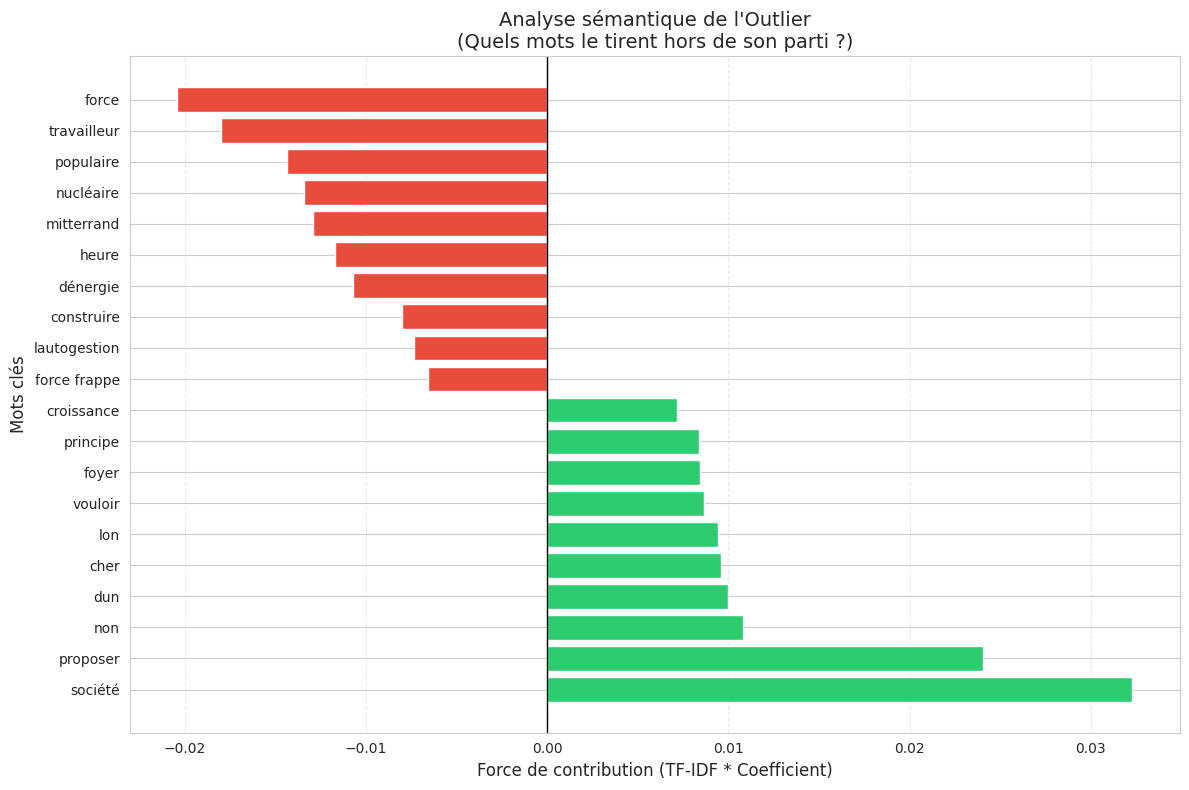

In [67]:
def plot_explanation(explanation, n=10):
    # On sélectionne les n mots les plus "orthodoxes" et les n plus "hérétiques"
    top_bottom = pd.concat([explanation.head(n), explanation.tail(n)])
    
    # On définit la couleur selon la contribution
    # Vert : confirme le parti / Rouge : crée l'atypicité
    top_bottom['color'] = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_bottom['contribution']]
    
    plt.figure(figsize=(12, 8))
    # Utilisation de la colonne 'contribution'
    bars = plt.barh(top_bottom['mot'], top_bottom['contribution'], color=top_bottom['color'])
    
    plt.axvline(0, color='black', linewidth=1, linestyle='-')
    plt.title("Analyse sémantique de l'Outlier\n(Quels mots le tirent hors de son parti ?)", fontsize=14)
    plt.xlabel("Force de contribution (TF-IDF * Coefficient)", fontsize=12)
    plt.ylabel("Mots clés", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()

# Relancer l'affichage
plot_explanation(exp)


In [83]:
from sklearn.neighbors import KNeighborsClassifier

# Coordinates for K-NN
coords = df_final_sans_cat_mixte[['tsne_1', 'tsne_2']].values
labels = df_final_sans_cat_mixte['titulaire-soutien'].values

# K-NN
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(coords, labels)

# Predict “geographical party”
df_final_sans_cat_mixte['parti_geographique'] = knn.predict(coords)

# Identify outliers
outliers_geo = df_final_sans_cat_mixte[
    df_final_sans_cat_mixte['titulaire-soutien'] != df_final_sans_cat_mixte['parti_geographique']
]

# Example: RPR points classified like PS
rpr_chez_ps = outliers_geo[
    (outliers_geo['titulaire-soutien'] == 'Rassemblement pour la République') & 
    (outliers_geo['parti_geographique'] == 'Parti socialiste')
]

print(f"Number of RPR candidates predicted as PS: {len(rpr_chez_ps)}")
display(rpr_chez_ps[['text_content', 'titulaire-soutien', 'parti_geographique']].head())


Number of RPR candidates predicted as PS: 3


,text_content,titulaire-soutien,parti_geographique
647,Sciences Po / fonds CEVIPOF\nElections Législa...,Rassemblement pour la République,Parti socialiste
857,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République,Parti socialiste
1462,Sciences Po / fonds CEVIPOF\nELECTIONS LEGISLA...,Rassemblement pour la République,Parti socialiste


Localité : Le K-NN ne se soucie pas de la moyenne du parti, il regarde les 10 voisins immédiats. Si un point est dans un "quartier" étranger, il est marqué.

Visualisation : Vous pouvez maintenant colorer votre t-SNE non pas par titulaire-soutien, mais par une colonne est_outlier_geo. Les points qui s'allument sont ceux qui sont "perdus" dans le territoire adverse.

Explication ciblée : L'analyse des mots ne cherche plus seulement pourquoi le texte est "bizarre", mais spécifiquement pourquoi il ressemble au PS plutôt qu'au RPR.

In [91]:
# Répartition globale des outliers géographiques
repartition_outliers = outliers_geo['titulaire-soutien'].value_counts()

# Proportion d'outliers par rapport à la taille totale du parti
total_par_parti = df_final_sans_cat_mixte['titulaire-soutien'].value_counts()
proportion_outliers = (repartition_outliers / total_par_parti * 100).fillna(0).round(2)

df_stats_geo = pd.DataFrame({
    'Nb Outliers (K-NN)': repartition_outliers,
    'Proportion (%)': proportion_outliers
}).sort_values(by='Nb Outliers (K-NN)', ascending=False)

print("Répartition des dissidents géographiques :")
display(df_stats_geo)

Répartition des dissidents géographiques :


,Nb Outliers (K-NN),Proportion (%)
titulaire-soutien,,
Union pour la démocratie française,3.0,4.29
Rassemblement pour la République,3.0,2.88
Parti communiste français,2.0,0.43
Parti socialiste,2.0,0.49
Front national,1.0,2.27
Lutte ouvrière,1.0,0.63
Parti socialiste unifié,1.0,0.68
Ligue communiste révolutionnaire,NaN,0.00
Mouvement des radicaux de gauche,NaN,0.00


In [90]:
# Tableau croisé : Parti Réel vs Parti du Voisinage (K-NN)
flux_outliers = outliers_geo.groupby(['titulaire-soutien', 'parti_geographique']).size().unstack(fill_value=0)

print("Matrice des transferts sémantiques (Où vont les outliers ?) :")
display(flux_outliers)

Matrice des transferts sémantiques (Où vont les outliers ?) :


parti_geographique,Parti communiste français,Parti socialiste,Rassemblement pour la République
titulaire-soutien,,,
Front national,0,0,1
Lutte ouvrière,1,0,0
Parti communiste français,0,2,0
Parti socialiste,1,0,1
Parti socialiste unifié,0,1,0
Rassemblement pour la République,0,3,0
Union pour la démocratie française,0,0,3


In [93]:
def expliquer_deplacement_geo(idx, df, X_matrix, coeffs, feature_names, partis):
    vrai_parti = df.loc[idx, 'titulaire-soutien']
    parti_accueil = df.loc[idx, 'parti_geographique']
    
    idx_vrai = list(partis).index(vrai_parti)
    idx_accueil = list(partis).index(parti_accueil)
    
    # Vecteur du document
    doc_vec = X_matrix[df.index.get_loc(idx)]
    
    # Calcul des mots qui favorisent le parti d'accueil au détriment du vrai parti
    # On cherche les mots où : (Coeff Parti Accueil > Coeff Parti Réel)
    ecart_coeffs = coeffs[idx_accueil] - coeffs[idx_vrai]
    contribution_deplacement = doc_vec * ecart_coeffs
    
    explanation = pd.DataFrame({
        'mot': feature_names,
        'poids_deplacement': contribution_deplacement
    }).sort_values(by='poids_deplacement', ascending=False)
    
    return vrai_parti, parti_accueil, explanation.head(10)

# Exemple pour le premier outlier RPR chez PS identifié
if not rpr_chez_ps.empty:
    target_idx = rpr_chez_ps.index[0]
    reel, accueil, mots_cles = expliquer_deplacement_geo(target_idx, df_final_sans_cat_mixte, X, coeffs, feature_names, partis)
    
    print(f"\nAnalyse de l'outlier {target_idx} : Réel={reel} -> Voisinage={accueil}")
    print("Mots qui expliquent l'attraction vers le parti d'accueil :")
    display(mots_cles)


Analyse de l'outlier 647 : Réel=Rassemblement pour la République -> Voisinage=Parti socialiste
Mots qui expliquent l'attraction vers le parti d'accueil :


,mot,poids_deplacement
1068,die,0.056466
1024,der,0.053113
3649,président,0.014689
4615,und,0.013075
2684,maire,0.010862
766,conseil,0.008655
4022,régional,0.006994
1989,général,0.005735
772,conseiller,0.005141
771,conseil régional,0.004733


Comme certains nuages de points sont très dispersés, cette mesure peut ne pas détecter certains outliers, nous allons donc implémenter une autre méthode pour la détection des outliers.

Distance au centre du Cluster (Le "Cœur" idéologique)
Pour chaque parti, on calcule son point moyen (centroïde) et on mesure qui s'en éloigne.

Pourquoi c'est puissant pour ton analyse ?
Le Centre : Tu identifies le "manifeste type" du PS ou du RPR en 1981 (celui qui a la distance_au_centre la plus faible).

Les Outliers : Si un manifeste de droite est classé à gauche avec 90% de confiance, c'est peut-être une erreur d'archivage ou un candidat qui a utilisé une rhétorique très spécifique (ex: gaullisme social).

PCA vs t-SNE : Le PCA te montrera peut-être un axe Gauche/Droite très clair (Axe 1), alors que le t-SNE te montrera si les "Radicaux de Gauche" sont vraiment un groupe à part ou s'ils sont noyés dans le PS.



1. Identifier les points "égarés" (Outliers de position)
Pour identifier mathématiquement un point rouge perdu chez les verts, on utilise les coordonnées t-SNE. On définit une zone de "contamination" ou on cherche les points dont les voisins les plus proches appartiennent à un autre parti.

1. L'Outlier de Classification (Erreur de "Logique")
C'est ce que nous avons fait avec le Random Forest et les probabilités (confiance > 0.8).

Définition : Le modèle prédit "Parti A" avec une certitude absolue, mais l'étiquette réelle est "Parti B".

Interprétation : C'est une anomalie textuelle. Soit le candidat a "trahi" son camp en utilisant le vocabulaire de l'adversaire, soit il y a une erreur d'étiquetage dans vos données.

Utilité : Identifier les discours de rupture ou les candidats atypiques (ex: un candidat de droite très social).

2. L'Outlier de Distance (Anomalie de "Position")
C'est ce que nous avons fait avec le calcul de la distance_au_centre (ou distance au centroïde).

Définition : Le texte est très éloigné du "cœur" statistique de son propre parti.

Interprétation : C'est une anomalie de style ou de thématique. Le texte ne ressemble à aucun autre dans son camp, sans pour autant ressembler forcément à l'adversaire. Il est simplement "marginal".

Utilité : Identifier les manifestes qui traitent de sujets très spécifiques, locaux, ou dont le ton est unique.

Comment combiner les deux pour une analyse "Expert" ?
Pour finaliser votre identification, vous pouvez croiser ces deux critères pour trouver les "Vrais Dissidents" de 1981 : ceux qui sont loin de leur centre ET que le modèle classe ailleurs.

Python
# 1. On combine les critères
# On cherche ceux qui sont loin de leur centre ET mal classés
dissidents = df_final[
    (df_final['distance_au_centre_global'] > df_final['distance_au_centre_global'].quantile(0.75)) & 
    (df_final['prediction'] != df_final['pole_politique'])
]

print(f"Nombre de 'dissidents sémantiques' identifiés : {len(dissidents)}")

# 2. Visualisation des dissidents sur le PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='pca_1', y='pca_2', hue='pole_politique', alpha=0.3)
sns.scatterplot(data=dissidents, x='pca_1', y='pca_2', color='black', marker='o', s=100, label='Dissidents')
plt.title("Localisation des dissidents sémantiques (Loin du centre + Mal classés)")
plt.show()
Ce qu'il vous reste à faire (en application) :
Si vous voulez vraiment boucler l'identification, il serait intéressant de regarder la "Similarité Cosinus par rapport au Centroïde adverse".

Si un candidat RPR a une similarité cosinus plus élevée avec le centroïde PS qu'avec son propre centroïde RPR, alors vous tenez mathématiquement un cas de "mimétisme politique".